<h1 align="center"> Statistics and Financial Data Science </h1>




GARCH examples
===

In [1]:
%reset -f

In [2]:
#import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import pandas_datareader as pd_data

In [3]:
# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

In [4]:
! pip install pmdarima
! pip install arch

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from datetime import datetime
# For splines
import patsy
from patsy import dmatrix
from arch import arch_model
from arch.univariate import ARX
from arch.univariate import GARCH
import pandas_datareader.data as web
import datetime as dt
import scipy.stats as st

In [6]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:

def plot_diagnosticsTight3(data,df=0):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Data")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True,auto_ylims=True)
    ax3.grid()

    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,model_df=df)#package version

    ax4.plot(ljbox_test['lb_pvalue'])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()

    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()

    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")

    plt.tight_layout()

In [8]:
import yfinance as yfin
yfin.pdr_override()
start_date = '2007-01-01'
end_date = '2022-01-01'

AAPL = pd_data.data.get_data_yahoo('AAPL', start_date,end_date)
AAPL.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.292877,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.264618,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,177.353622,62348900
2021-12-30,179.470001,180.570007,178.089996,178.199997,176.186951,59773000
2021-12-31,178.089996,179.229996,177.259995,177.570007,175.564072,64062300


In [9]:
# Let's look at the returns
AAPLRet = np.log(AAPL['Adj Close']).diff().dropna()
AAPLRet.head()

Date
2007-01-04    0.021953
2007-01-05   -0.007147
2007-01-08    0.004926
2007-01-09    0.079800
2007-01-10    0.046746
Name: Adj Close, dtype: float64

1) Plot ACF/PACF for first impression on autoregressive features

2) Test for stationarity (otherwise transform)

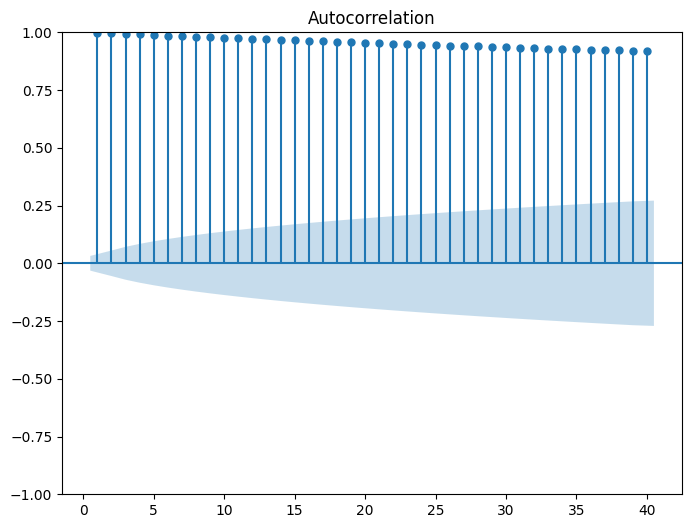

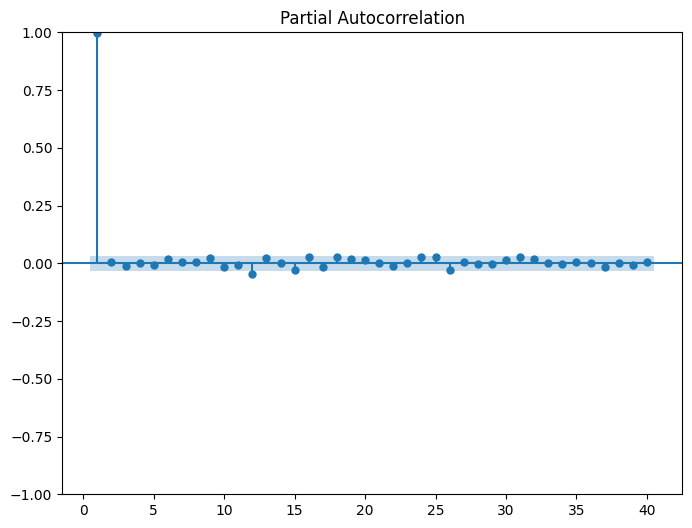

In [10]:
plot_acf(AAPL['Adj Close'],zero = False, lags = 40);
plot_pacf(AAPL['Adj Close'], zero = False, lags =40);
plt.show()

In [11]:
# Existence of Unit Root
test = adfuller(AAPL['Adj Close'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: 4.099030
p-value: 1.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [12]:
# Kpss test rejects stationarity
test = kpss(AAPL['Adj Close'])
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 6.719110
p-value: 0.010000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


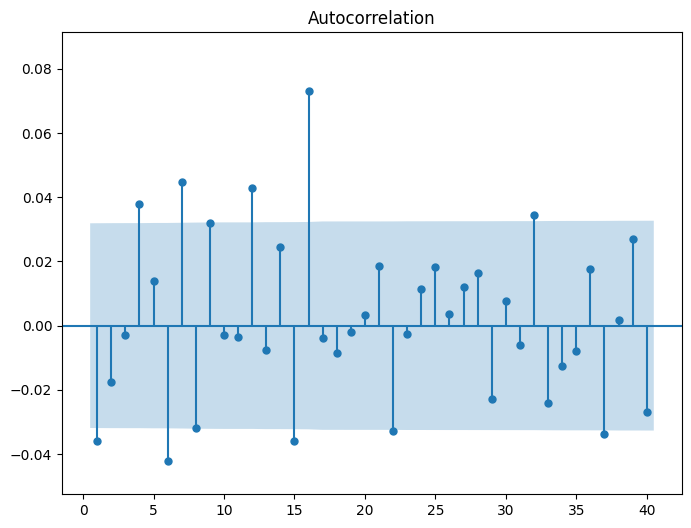

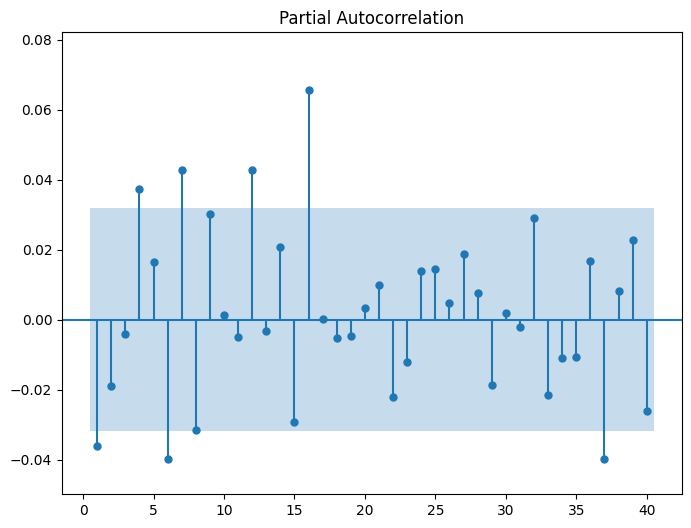

In [13]:
plot_acf(AAPLRet,zero = False, lags = 40,auto_ylims=True);
plot_pacf(AAPLRet, zero = False, lags =40,auto_ylims=True);
plt.show()

Data passes the stationarity tests - I can consider modelling as an ARMA process
===

In [14]:
# Reject Unit Root
test = adfuller(AAPLRet)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -13.815718
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [15]:
# Kpss test supports stationarity
test = kpss(AAPLRet)
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.063946
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


3) Find / fit best ARMA model (already differenced once).

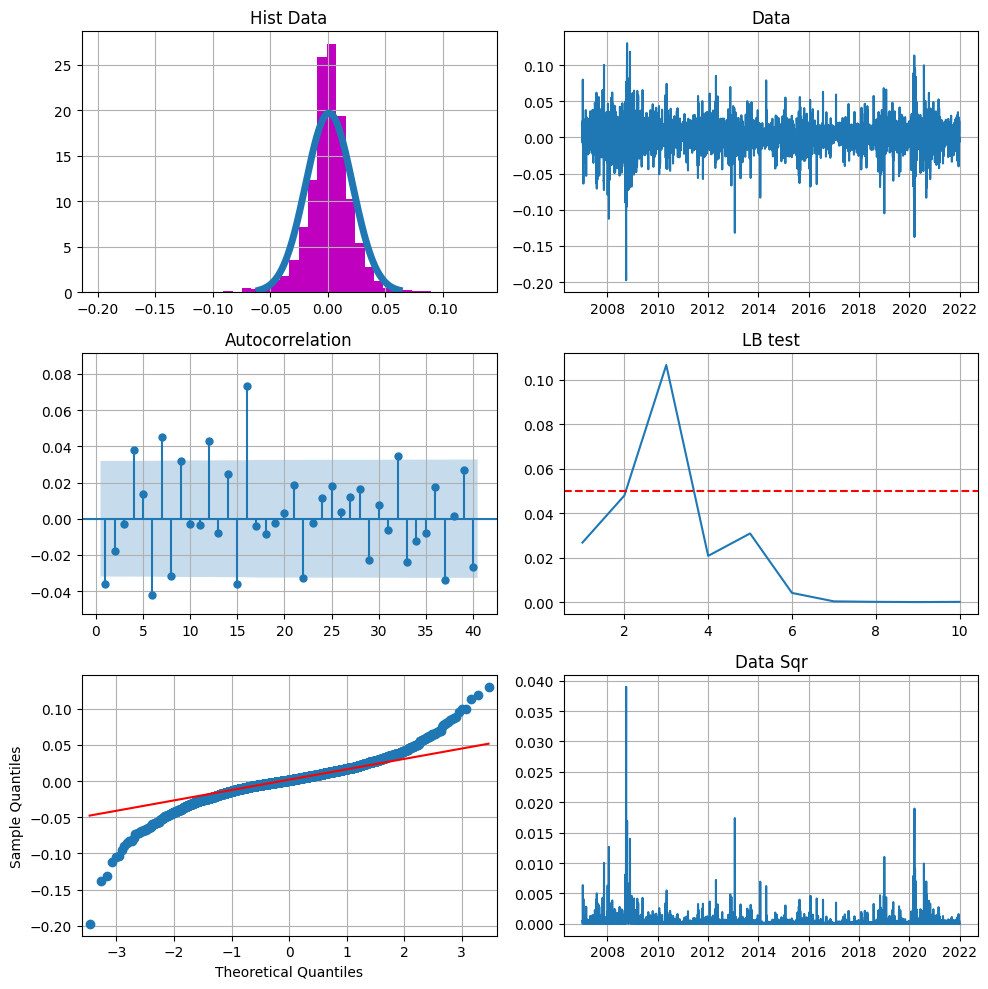

In [16]:
# Just plotting graphs on the actual data and examining the results fo the Ljung-Box test...
# I see that there is auto-correlation

plot_diagnosticsTight3(AAPLRet)

In [17]:
# So can fit an ARMA type model
results = pm.auto_arima(AAPLRet, trace = True, seasonal=False,
                        stationary = True, stepwise = False,with_intercept=True,
                        information_criterion='aic', start_q=0, max_p = 6, max_q = 1,d=0)
# Order selected is given in summary
print(results.summary())
# This chooses AR 2 model for the mean

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-18725.241, Time=1.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-18728.326, Time=3.70 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-18728.142, Time=3.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-18725.749, Time=3.80 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-18727.495, Time=2.63 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-18725.132, Time=1.63 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-18725.558, Time=3.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-18723.537, Time=4.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-18728.875, Time=2.51 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-18726.956, Time=10.68 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-18727.928, Time=7.63 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 44.464 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3776
Model:         

In [18]:
?pm.auto_arima

In [19]:
model = sm.tsa.SARIMAX(AAPLRet, trend='c',order=(4, 0, 0))
fit = model.fit(disp = False)
print(fit.summary());

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3776
Model:               SARIMAX(4, 0, 0)   Log Likelihood                9370.437
Date:                Wed, 22 Nov 2023   AIC                         -18728.875
Time:                        03:08:34   BIC                         -18691.456
Sample:                             0   HQIC                        -18715.572
                               - 3776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.000      3.328      0.001       0.000       0.002
ar.L1         -0.0367      0.010     -3.720      0.000      -0.056      -0.017
ar.L2         -0.0180      0.011     -1.701      0.0

4) Plot Diagnostics on residuals of the model

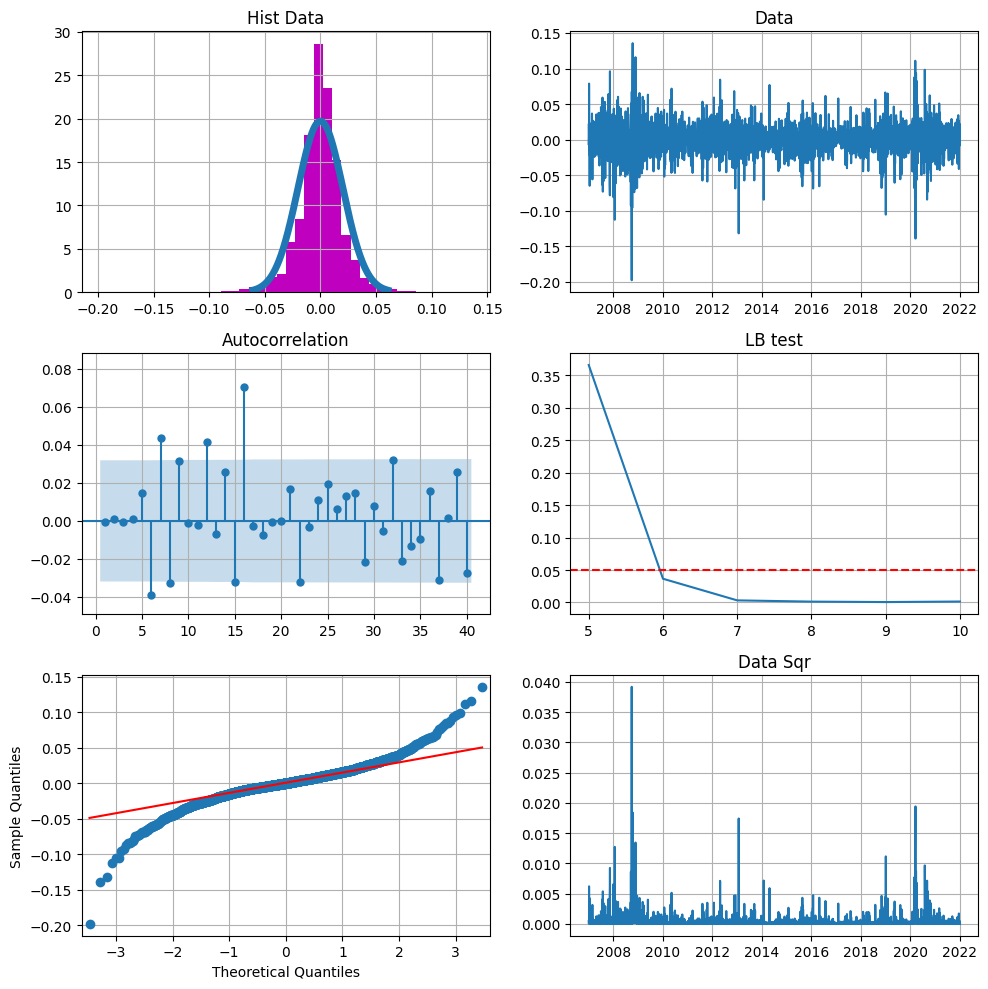

In [20]:
plot_diagnosticsTight3(fit.resid,4)

There is no auto-correlation and residuals do not pass the Ljung-Box test, there also seem to be clusters
in the data and also the QQ plot does not fit with normality. There could be due to heteroskedasticity - so we examine
the squared residulas

5) Check squared residuals ACF/PACF - these indicate some AR with order maybe 5 - 9, depending on how complex we wish model to be.

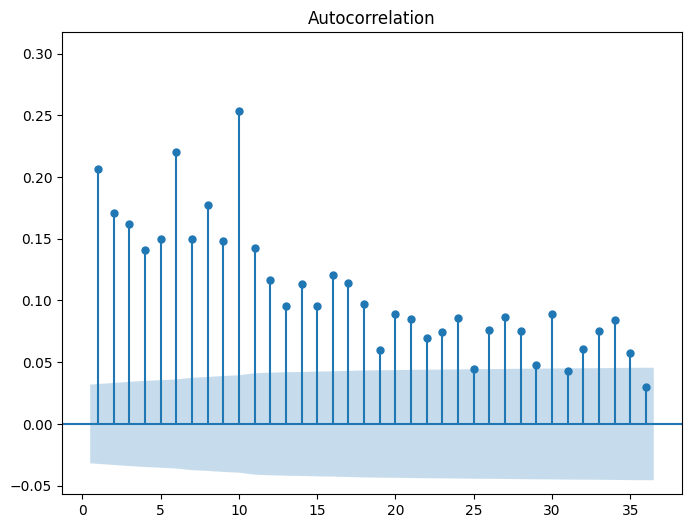

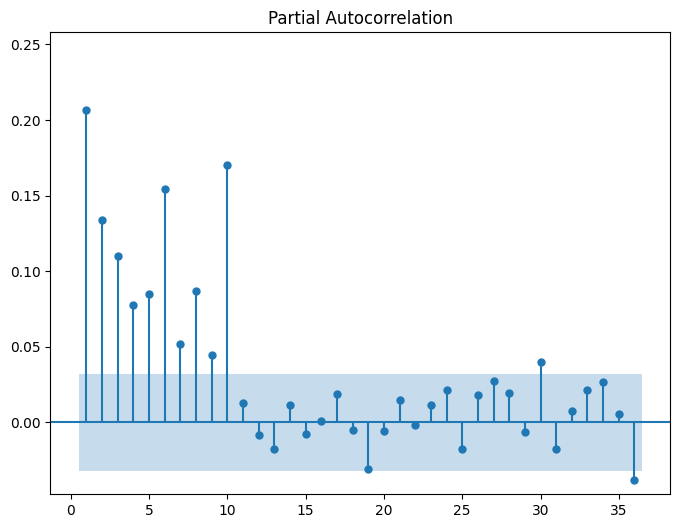

In [21]:
plot_acf(fit.resid**2, zero = False,auto_ylims=True);
plot_pacf(fit.resid**2, zero = False,auto_ylims=True);

plt.show()

In [22]:
# Above were examples with SARIMAX which are familiar with. In arch_model we need to
# specify a mean model using a different method - this is restricted to AR type only, with
# potential external regressors.

6) Combine the models by specifying the mean and vol processes into a GARCH model:

In [23]:
# The model allows us to choose specific lags - this is very similar to the SARIMAX function from statsmodels:
# Diff are possibly due to numerical approx / methods/ tolerance
from arch.univariate import ARX

arx = ARX(AAPLRet, lags= 4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(4,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9576.778101226095
            Iterations: 18
            Function evaluations: 254
            Gradient evaluations: 14
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:                9576.78
Distribution:                  Normal   AIC:                          -19133.6
Method:            Maximum Likelihood   BIC:                          -19071.2
                                        No. Observations:                 3772
Date:                Wed, Nov 22 2023   Df Residuals:                     3767
Time:                        03:08:38   Df Model:                            5
                                   Mean Model                                 

- I'm suspiscious on the convergence of the model as all alphas are the same.
- We can try using the rescale function to see if we obtain an improvement or
- We can try to scale the returns (by x 100)... let's try both and watch the effect on coefficients

In [24]:
arx = ARX(AAPLRet, lags= 4,rescale = True) #this is eq. to AR(4) as per above
arx.volatility = GARCH(4,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7638.754461512257
            Iterations: 22
            Function evaluations: 271
            Gradient evaluations: 22
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.009
Mean Model:                        AR   Adj. R-squared:                 -0.010
Vol Model:                       ARCH   Log-Likelihood:               -7638.75
Distribution:                  Normal   AIC:                           15297.5
Method:            Maximum Likelihood   BIC:                           15359.9
                                        No. Observations:                 3772
Date:                Wed, Nov 22 2023   Df Residuals:                     3767
Time:                        03:08:38   Df Model:                            5
                                   Mean Model                                  

In [25]:
newAAPLRet =AAPLRet*100
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(4,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7638.754461512257
            Iterations: 22
            Function evaluations: 271
            Gradient evaluations: 22
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.009
Mean Model:                        AR   Adj. R-squared:                 -0.010
Vol Model:                       ARCH   Log-Likelihood:               -7638.75
Distribution:                  Normal   AIC:                           15297.5
Method:            Maximum Likelihood   BIC:                           15359.9
                                        No. Observations:                 3772
Date:                Wed, Nov 22 2023   Df Residuals:                     3767
Time:                        03:08:39   Df Model:                            5
                                   Mean Model                                  

Try different GARCH models, GARCH(1,1) gives the lowest AIC.

In [26]:
arx = ARX(AAPLRet, lags= 4,rescale = True) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7523.744689887207
            Iterations: 14
            Function evaluations: 153
            Gradient evaluations: 14
                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.002
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -7523.74
Distribution:                  Normal   AIC:                           15063.5
Method:            Maximum Likelihood   BIC:                           15113.4
                                        No. Observations:                 3772
Date:                Wed, Nov 22 2023   Df Residuals:                     3767
Time:                        03:08:39   Df Model:                            5
                                   Mean Model                                  

7) Analyse outputs and consider diagnostics of model

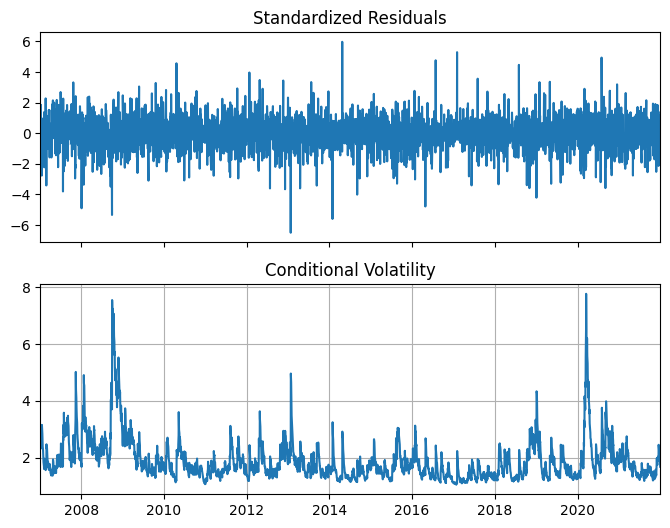

In [27]:
# Exploring the outputs
res.plot()
plt.grid()
plt.show()

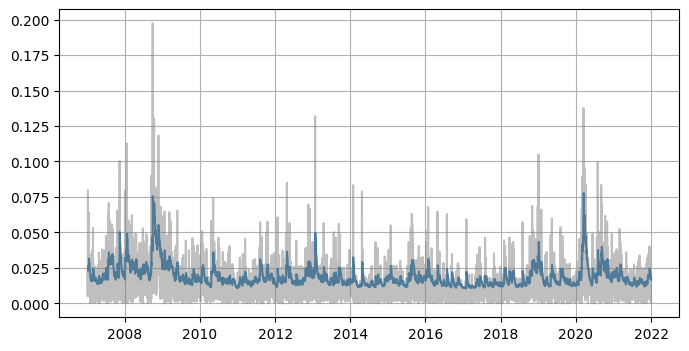

In [28]:
# Plot conditional vol vs abs(ret)
plt.figure(1, figsize=(8,4))
plt.plot(res.conditional_volatility/100) # just a rescale
plt.plot(abs(AAPLRet), color = 'grey', alpha = 0.5)
plt.grid()
plt.show()

7) Consider Diagnostics of StdResiduals: Ljung-Box tests to verify no autocorrelation and normality tests

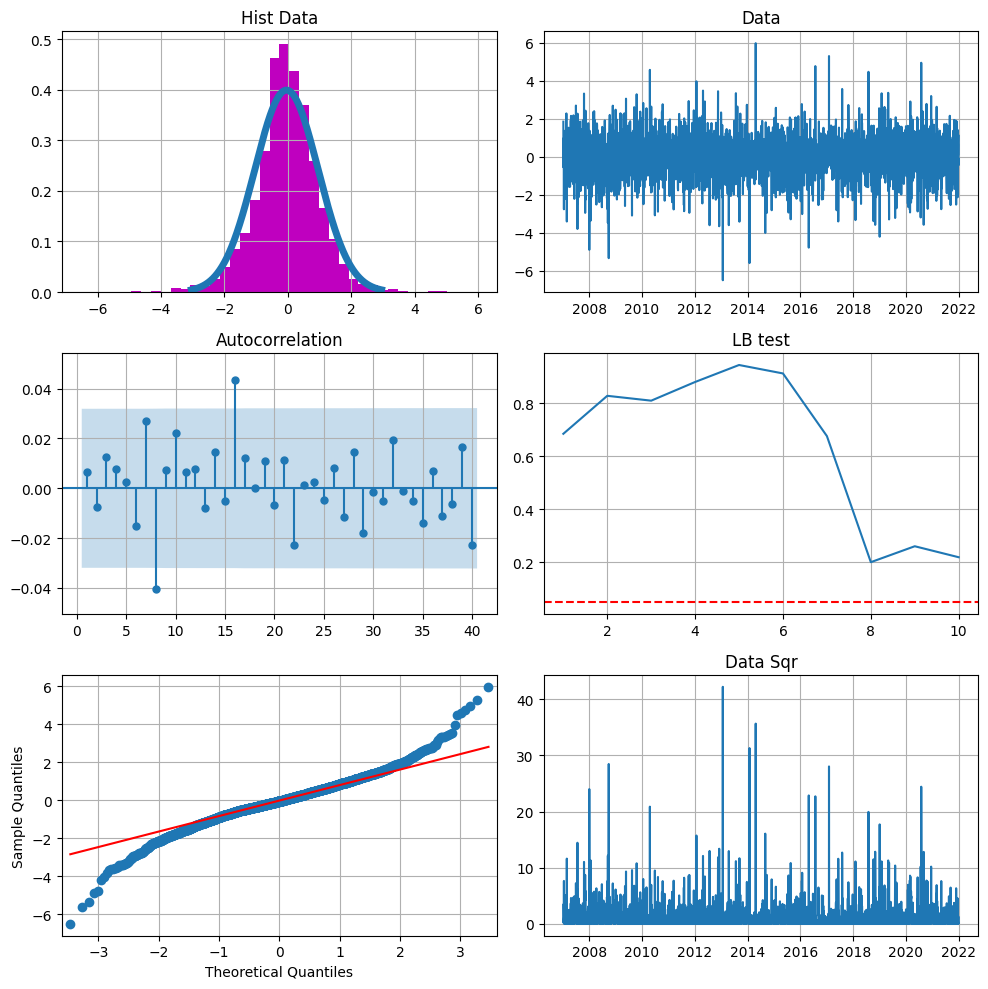

In [29]:
std_resid = res.resid/res.conditional_volatility
std_resid = std_resid.dropna()
plot_diagnosticsTight3(std_resid)

- The standardized residuals have passed the Ljung-Box test, supporting the case that they are white noise
- However, the QQ plot still does not seem to fit a normal, potentially a different distribution shoudl be considered.
- We should verify by formal normality tests: both reject hypothesis of normality.

In [30]:
JB_test = stats.jarque_bera(std_resid)
print('Jarque-Bera statitiscs: ', JB_test[0])
print('Jarque-Bera p-value: ', JB_test[1])

Jarque-Bera statitiscs:  1322.4045041355414
Jarque-Bera p-value:  6.974458668986367e-288


In [31]:
shap_test = stats.shapiro(std_resid)
print('Shapiro statitiscs: ', shap_test[0])
print('Shapiro p-value: ', shap_test[1])

Shapiro statitiscs:  0.9734284281730652
Shapiro p-value:  6.246327604841905e-26


8) Forecasting using the model

More details can be found at https://arch.readthedocs.io/en/latest/univariate/forecasting.html

Here the notatios follows the convention say for GARCH(1,1) with constant mean:

$$r_t = \mu + \epsilon_t$$
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma^2_{t-1}$$
$$ \epsilon_t = \sigma_t e_t, \quad \ e_t \sim N(0,1)$$

In [32]:
split_date = dt.datetime(2021,1,1)

arx = ARX(AAPLRet, lags= 4,rescale = True) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
res = arx.fit(update_freq=0,last_obs=split_date) #split_date is not included in fitting
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7057.600271717585
            Iterations: 14
            Function evaluations: 151
            Gradient evaluations: 14
                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.003
Mean Model:                        AR   Adj. R-squared:                 -0.004
Vol Model:                      GARCH   Log-Likelihood:               -7057.60
Distribution:                  Normal   AIC:                           14131.2
Method:            Maximum Likelihood   BIC:                           14180.5
                                        No. Observations:                 3520
Date:                Wed, Nov 22 2023   Df Residuals:                     3515
Time:                        03:08:43   Df Model:                            5
                                   Mean Model                                  

In [33]:
forecasts = res.forecast(horizon=5,start=split_date) # provide forecasting from start date
forecasts.mean.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2021-01-04,0.134722,0.187018,0.251788,0.106946,0.188957
2021-01-05,0.204026,0.253108,0.069852,0.223465,0.190608
2021-01-06,0.196707,0.065475,0.346475,0.076174,0.194715
2021-01-07,0.114578,0.350285,-0.030920,0.294342,0.185399
2021-01-08,0.361865,-0.030021,0.269089,0.208893,0.205327


In [34]:
forecasts = res.forecast(horizon=5) #by default start date = last data used for fitting -1
forecasts.mean.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-12-31,0.336191,0.178859,0.190443,0.155527,0.196496
2021-01-04,0.134722,0.187018,0.251788,0.106946,0.188957
2021-01-05,0.204026,0.253108,0.069852,0.223465,0.190608
2021-01-06,0.196707,0.065475,0.346475,0.076174,0.194715
2021-01-07,0.114578,0.350285,-0.030920,0.294342,0.185399


In [35]:
forecasts.variance.tail()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2021-12-27,3.803455,3.820514,3.836098,3.855504,3.873814
2021-12-28,3.441307,3.470945,3.498756,3.529544,3.558896
2021-12-29,3.059281,3.102189,3.142897,3.185694,3.226692
2021-12-30,2.807153,2.858819,2.908040,2.958761,3.007446
2021-12-31,2.567473,2.627464,2.684777,2.743032,2.799024


In [36]:
print(forecasts.mean.iloc[:2])
print(forecasts.variance.iloc[-1:])
print(forecasts.residual_variance.iloc[-1:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-12-31  0.336191  0.178859  0.190443  0.155527  0.196496
2021-01-04  0.134722  0.187018  0.251788  0.106946  0.188957
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-12-31  2.567473  2.627464  2.684777  2.743032  2.799024
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-12-31  2.567473  2.626844  2.684138  2.739428  2.792784


In [37]:
# Using simulation method
forecasts = res.forecast(horizon=5,method = 'simulation')
print(forecasts.mean.iloc[:2])
print(forecasts.variance.iloc[-2:])
print(forecasts.residual_variance.iloc[-2:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-12-31  0.336191  0.178859  0.190443  0.155527  0.196496
2021-01-04  0.134722  0.187018  0.251788  0.106946  0.188957
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-12-30  2.807153  2.867280  2.920451  2.959033  3.000984
2021-12-31  2.567473  2.627449  2.687673  2.724207  2.787601
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-12-30  2.807153  2.866602  2.919754  2.955096  2.994178
2021-12-31  2.567473  2.626828  2.687035  2.720603  2.781366


Using Simulations in Forecast

In [38]:
# To illustrate example, set number of simulations to 6 and look at 3 step horizon:

forecasts = res.forecast(horizon=3, method = 'simulation',simulations = 6)
print(forecasts.mean.iloc[-4:])
print(forecasts.variance.iloc[-4:])
print(forecasts.residual_variance.iloc[-4:])

#This will query expected values for the last 4 dates and display all horizons's expected values above.

                 h.1       h.2       h.3
Date                                    
2021-12-28  0.219414  0.126626  0.284854
2021-12-29  0.123995  0.284650  0.172996
2021-12-30  0.272462  0.172050  0.215980
2021-12-31  0.162309  0.215224  0.183017
                 h.1       h.2       h.3
Date                                    
2021-12-28  3.441307  3.458069  3.466763
2021-12-29  3.059281  3.319898  3.383403
2021-12-30  2.807153  2.726158  2.685127
2021-12-31  2.567473  2.562876  2.629944
                 h.1       h.2       h.3
Date                                    
2021-12-28  3.441307  3.457237  3.465923
2021-12-29  3.059281  3.319159  3.382596
2021-12-30  2.807153  2.725479  2.684464
2021-12-31  2.567473  2.562256  2.629321


In [39]:
# What is the shape of this variable?
print(forecasts.simulations.values.shape)

# First dimension is 253 which is the number of points for forecasting
# Second dimension is the number of simulations
# Third dimenstion, the number of horizons (h-steps ahead)

# If we used all points in our fitting, the forecasts only return the last point.

(253, 6, 3)


In [40]:
# To get the value of the LAST path, all 3 horizon simulations (h1,h2,h3) on the LAST date 2021-12-31:
forecasts.simulations.values[-1,-1,:]

array([-0.24680907, -1.31129154,  1.44859051])

In [41]:
# To get the value of all simulations of h3 (only) on the LAST date
forecasts.simulations.values[-1,:,2]
# 6 simulations for 3-step ahead horizon generated.

array([-1.6784895 , -2.23217348, -1.27195711, -0.32882443, -0.28863005,
        1.44859051])

In [42]:
# Change horizon to 5 and increase the number of simulations - this is exciting!
forecasts = res.forecast(horizon=5, method = 'simulation',simulations = 10)

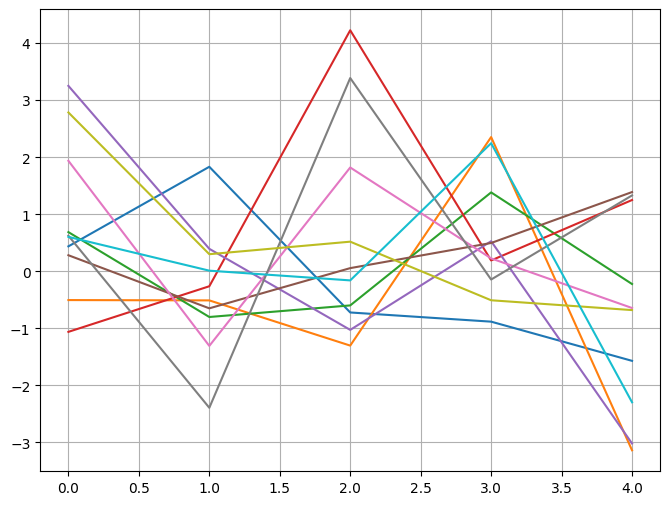

In [43]:
# To get ALL the paths, all 5 horizon simulations (h1..h5):
paths = forecasts.simulations.values[-1,:,:].T #Each path is a sequence of h1,h2,h3,h5 (and 10 paths displayed)
plt.plot(paths);
plt.grid()
plt.show()

In [44]:
# Why do I need to transpose?
forecasts.simulations.values[-1,:,:].shape
# 10 by 5, I'm interested in the data as a 5 by 10 (5 points in the x axis for horizon, y is the value of each horizon path)

(10, 5)

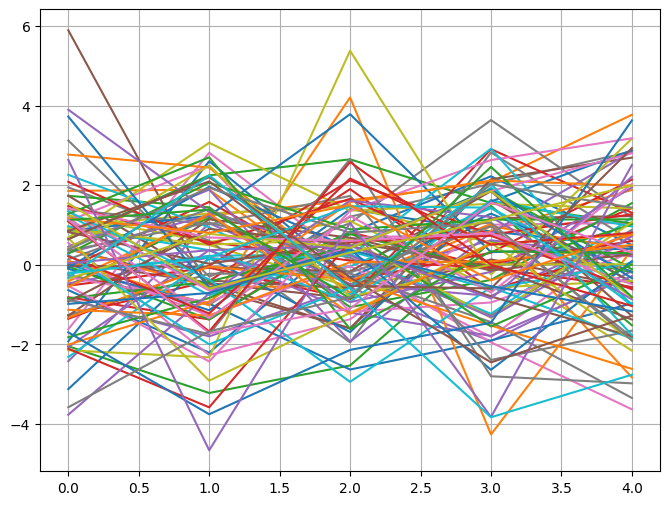

In [45]:
# Let's go crazy... 100 paths, what do we see now?
forecasts = res.forecast(horizon=5, method = 'simulation',simulations = 100)
paths = forecasts.simulations.values[-1,:,:].T
#Each path is a sequence of h1,h2,h3,h5 (and 100 paths displayed)
plt.plot(paths);
plt.grid()
plt.show()

In [46]:
# To get a cross sample of all forecasts at a particular point in time, say all simulations of h-steps-ahead:
h1_values = forecasts.simulations.values[-1,:,0]
h2_values = forecasts.simulations.values[-1,:,1]
h3_values = forecasts.simulations.values[-1,:,2]
h4_values = forecasts.simulations.values[-1,:,3]
h5_values = forecasts.simulations.values[-1,:,4]

In [47]:
# Hence, if I'm interested in the forecast of 5-day ahead, I can look at the distribution of the simulation
# to get confidence bounds around mean.
print(h5_values.mean())
print(h5_values.std())
# Find the quantiles
print(np.quantile(h5_values,0.025))
print(np.quantile(h5_values,0.975))

0.24294228647651012
1.6021685117062618
-2.910046236887661
3.175996936333154


In [48]:
# Repeating for a more realistic number of simulations:
# Using simulation method
forecasts = res.forecast(horizon=5, method = 'simulation',simulations = 1000)
h5_values = forecasts.simulations.values[-1,:,-1]
h5_values.shape

(1000,)

0.1254121592890712
1.6153546651423563
-2.900883494468315
3.365869769078692


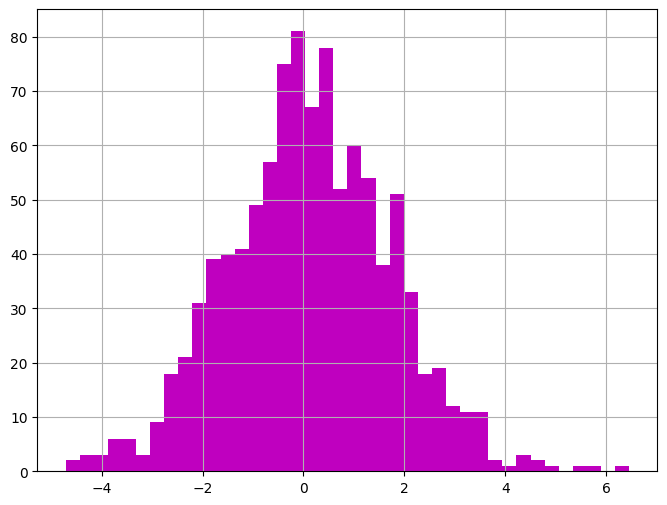

In [49]:
print(h5_values.mean())
print(h5_values.std())
# Find the quantiles
print(np.quantile(h5_values,0.025))
print(np.quantile(h5_values,0.975))
plt.hist(h5_values,bins = 40, color = 'm')
plt.grid()
plt.show()

In [50]:
# 30 day horizon, 1000 simulation points
numSim = 1000
numH = 30
forecasts = res.forecast(horizon= numH, method = 'simulation',simulations = numSim)
hLast_values = forecasts.simulations.values[-1,:,-1]
hLast_values.shape

(1000,)

In [51]:
######################################################################################
#
# Firstly I would like to find the mean of the forecast and the 95% conf interval
# For that, will pick up at the last observation (3149, the h1,...,h100 of each path)
# At every step, I can then get statistics across the paths at every step h1,...,h100
#
######################################################################################

def plotHorizonForecast(data,tsData,getStats=False):
        #myData = sims.values

        numSims = data.shape[0]
        numH = data.shape[1]

        path = np.zeros(numSim)
        sizeNumH = numH + 1
        crossSlice = np.zeros((numH+1,numSims))

        mean = np.zeros(numH+1)
        Q95up = np.zeros(numH+1)  #0.975
        Q95down = np.zeros(numH+1) #0.275
        Q80up = np.zeros(numH+1)  #0.90
        Q80down = np.zeros(numH+1) #0.10

        # Add last obs as point
        lastObsValue = tsData[tsData.index[-1]]

        for j in range(numSims): #for each path e
            crossSlice[0][j] = lastObsValue

        for j in range(numSims):
            for i in range(numH):
                crossSlice[i+1][j] = data[j][i]

        type(crossSlice)
        for i in range(1,numH+1):
            mean[i] = stats.describe(crossSlice[i,:]).mean
            Q95up[i] = np.quantile(crossSlice[i,:],0.975)
            Q95down[i] = np.quantile(crossSlice[i,:],0.025)
            Q80up[i] = np.quantile(crossSlice[i,:],0.9)
            Q80down[i] = np.quantile(crossSlice[i,:],0.1)


        plt.figure(1, figsize=(16,16))
        plt.plot(mean, color = 'm', alpha = 1)
        plt.plot(Q95up, color = 'r')
        plt.plot(Q95down, color = 'r')
        plt.plot(Q80up,color = 'g')
        plt.plot(Q80down,color = 'g')
        plt.grid()
        plt.show()
        if(getStats):
            myList = [mean,Q95up,Q95down,Q80up,Q80down]
            myNames= ['mean','Q95up','Q95down','Q80up','Q80down']
            myDict = dict(zip(myNames, myList))
            return myDict

In [52]:
sims = forecasts.simulations
sims.values[-1,:,:].shape
x = sims.values[-1,:,:]

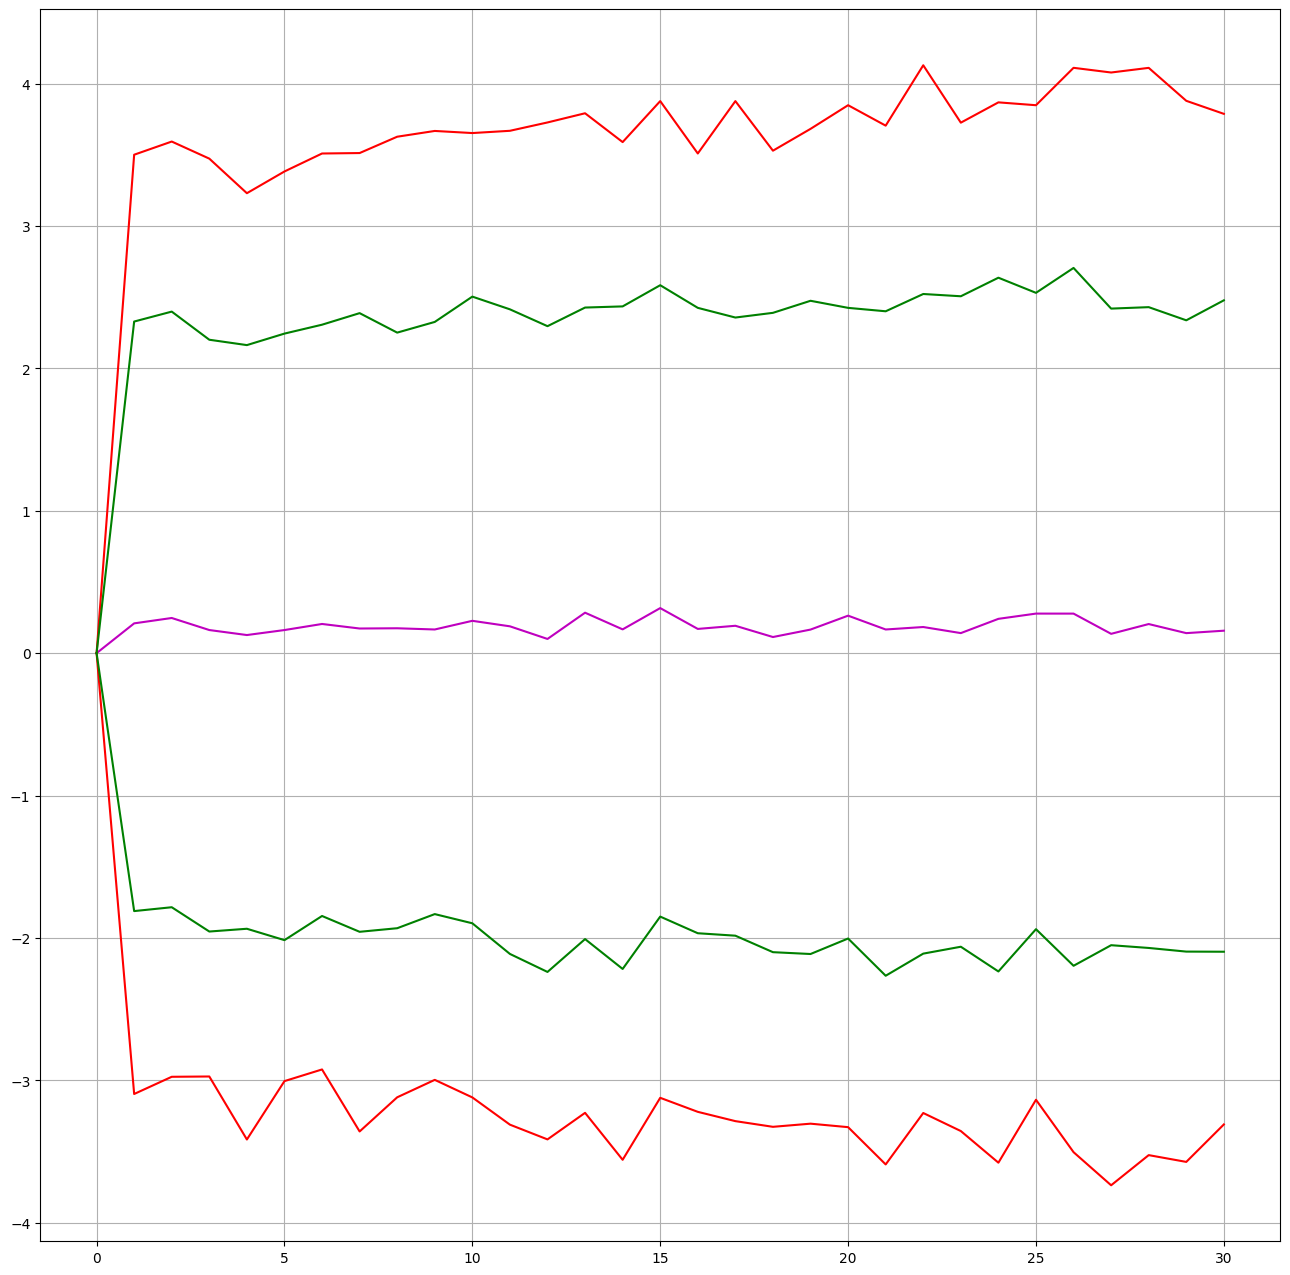

In [53]:
plotHorizonForecast(x,AAPLRet)

In [54]:
# If I use all the data in fitting, forecasts only has one row
arx = ARX(AAPLRet, lags= 4,rescale = True) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
res_full = arx.fit(update_freq=0)#, tol=0.000001
print(res_full.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7523.744689887207
            Iterations: 14
            Function evaluations: 153
            Gradient evaluations: 14
                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.002
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -7523.74
Distribution:                  Normal   AIC:                           15063.5
Method:            Maximum Likelihood   BIC:                           15113.4
                                        No. Observations:                 3772
Date:                Wed, Nov 22 2023   Df Residuals:                     3767
Time:                        03:08:47   Df Model:                            5
                                   Mean Model                                  

In [55]:
# To illustrate example, set number of simulations to 6 and look at 3 step horizon:

forecasts_full = res_full.forecast(horizon=3, method = 'simulation',simulations = 6)
print(forecasts_full.mean.iloc[-4:])
print(forecasts_full.variance.iloc[-4:])
print(forecasts_full.residual_variance.iloc[-4:])

                 h.1       h.2       h.3
Date                                    
2021-12-31  0.159991  0.214144  0.180722
                h.1      h.2       h.3
Date                                  
2021-12-31  2.56632  2.72598  2.985321
                h.1       h.2       h.3
Date                                   
2021-12-31  2.56632  2.725586  2.984898


In [56]:
print(forecasts_full.simulations.values.shape)

(1, 6, 3)


In order to be able to forecast with external regressors, we need split the original data for training  
===

- We can use original data and choose to fit the model up to a date, forecasting with the rest or
- We can extend the dataframe with a dummy for the "future dates" and give future values for external regressor

In [57]:
# We will use examples with simulation - for the purpose of this example, we will simply slice the
# data as the "last_obs" to fit the model and all other points are ignored. Only the dates are
# used for the future forecasting.
# Quickly figure out 100 days before last obs
AAPLRet.to_frame().shift(-100).tail(101)
#That is 2021-08-10: use this as last_obs as python won't include in the fitting of the model

,Adj Close
Date,
2021-08-10,-0.003542
2021-08-11,NaN
2021-08-12,NaN
2021-08-13,NaN
2021-08-16,NaN
...,...
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN


In [58]:
split_date = dt.datetime(2021,8,11)

newAAPLRet = AAPLRet*100
arx = ARX(newAAPLRet, lags= 4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
res = arx.fit(update_freq=0,last_obs=split_date)
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7344.305971421418
            Iterations: 14
            Function evaluations: 151
            Gradient evaluations: 14
                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.002
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -7344.31
Distribution:                  Normal   AIC:                           14704.6
Method:            Maximum Likelihood   BIC:                           14754.3
                                        No. Observations:                 3672
Date:                Wed, Nov 22 2023   Df Residuals:                     3667
Time:                        03:08:48   Df Model:                            5
                                   Mean Model                                  

In [59]:
numH = 100
forecasts = res.forecast(horizon=numH, method='simulation') #default number of simulations is 1000
sims = forecasts.simulations

In [60]:
forecasts.mean.head()

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-10,0.201761,0.171683,0.199157,0.169548,0.190077,0.188198,0.190258,0.188473,0.189276,0.189141,...,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216
2021-08-11,0.171410,0.199112,0.170362,0.189238,0.188181,0.190226,0.188531,0.189246,0.189141,0.189276,...,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216
2021-08-12,0.221139,0.174034,0.123505,0.255958,0.191581,0.191101,0.184495,0.191536,0.189255,0.189454,...,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216
2021-08-13,0.173097,0.123349,0.258754,0.188697,0.191043,0.184385,0.191738,0.189153,0.189455,0.188953,...,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216
2021-08-16,0.137053,0.261039,0.147800,0.233212,0.185228,0.193336,0.186197,0.190945,0.188940,0.189472,...,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216,0.189216


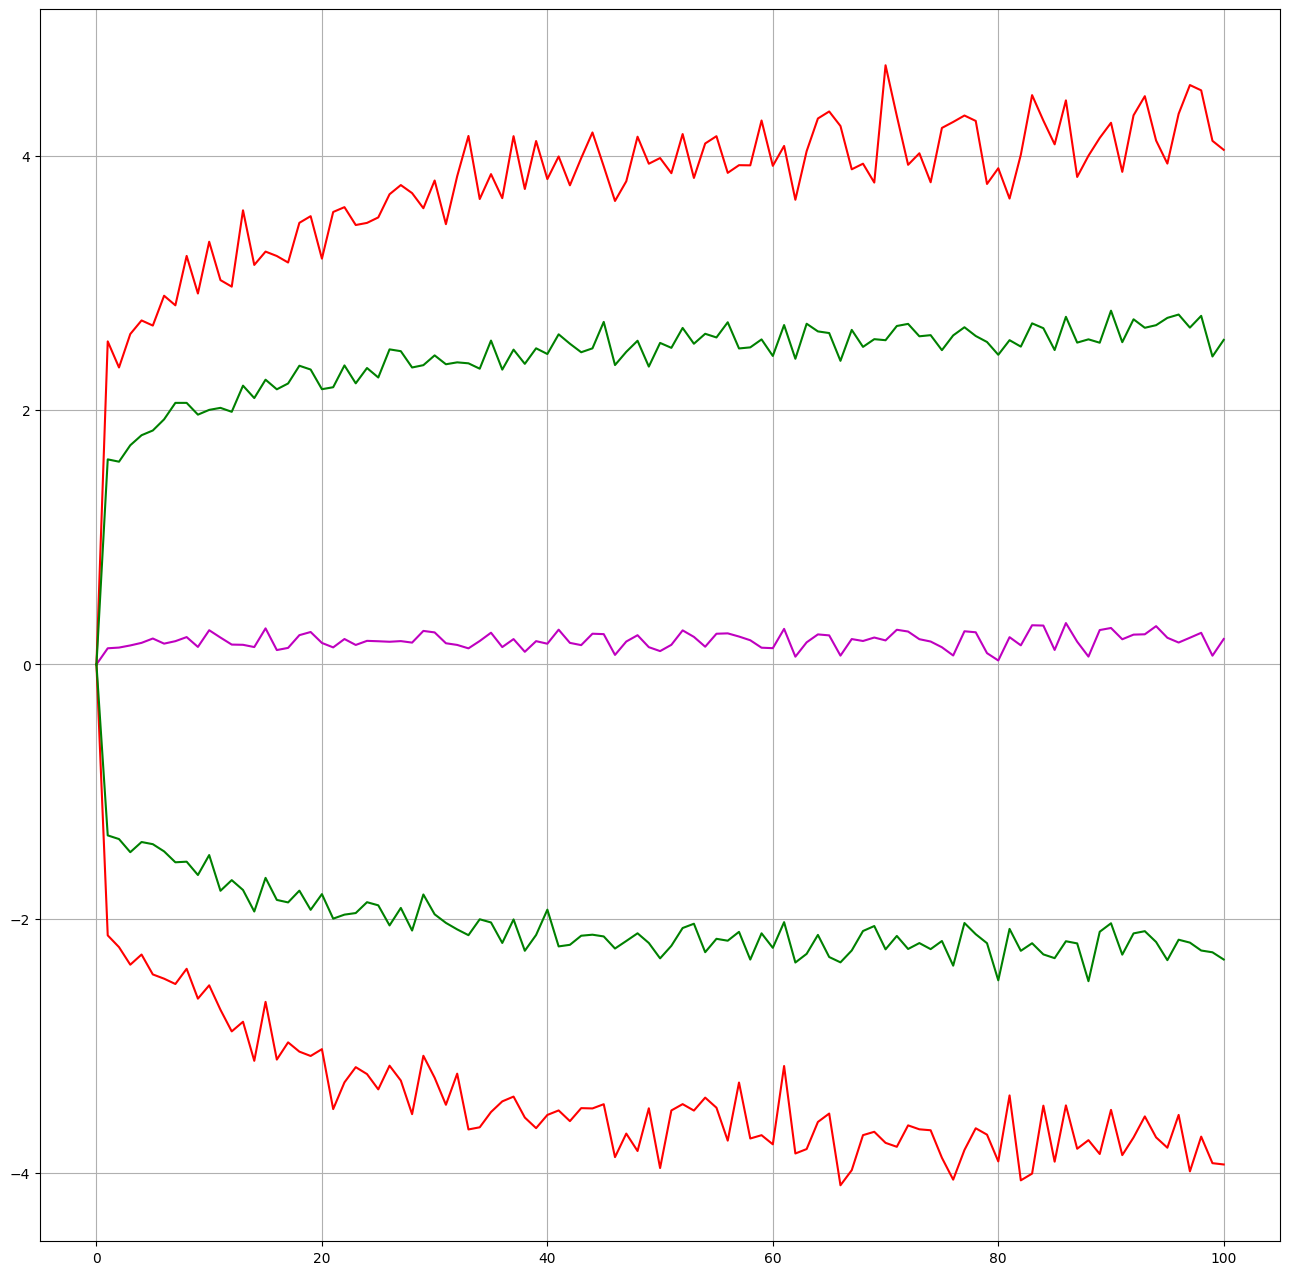

In [61]:
# forecast at 2021-08-10 for the following 100 days (from 2021-08-11 to 2021-12-31)
statsRtn = plotHorizonForecast(sims.values[1,:,:],tsData=AAPLRet.loc[AAPLRet.index<split_date], getStats=True)

Example to then forecast the actual price given the forecast of the returns
===

In [62]:
prices = AAPL['Adj Close']
lastPrice = prices[prices.index[-101]] #price on 2021-08-10
lastPrice

143.7454071044922

In [63]:
prices.tail(101)

Date
2021-08-10    143.745407
2021-08-11    144.002090
2021-08-12    146.993500
2021-08-13    147.200851
2021-08-16    149.195099
                 ...    
2021-12-27    178.292877
2021-12-28    177.264618
2021-12-29    177.353622
2021-12-30    176.186951
2021-12-31    175.564072
Name: Adj Close, Length: 101, dtype: float64

In [64]:
def getPaths(data):
    numSim = data.shape[0]
    numH  = data.shape[1]
    totValueAcrossPath = np.zeros(numSim)
    for j in range(numSim): #for each path
        for i in range(numH):
            totValueAcrossPath[j] =  totValueAcrossPath[j] + data[j][i]

    return totValueAcrossPath

In [65]:
print(sims.values[1,:,:].shape)#100 day forecast from 2021-08-11
totReturnPaths = getPaths(sims.values[-1,:,:])
totReturnPaths.shape
# It contains the total path value

(1000, 100)


(1000,)

totReturnPaths has added all the daily return for the forecast of 100 days ahead, path by path
===

In [66]:
# Now I can exponentite to get back original price
# But remember: you must scale back your returns if you have use this trick...
# And remember to use your initial spot the last spot observation

sizeN = len(totReturnPaths)
spotPrices = np.zeros(sizeN)
for i in range(sizeN):
    spotPrices[i] = np.exp(totReturnPaths[i]/100)*lastPrice


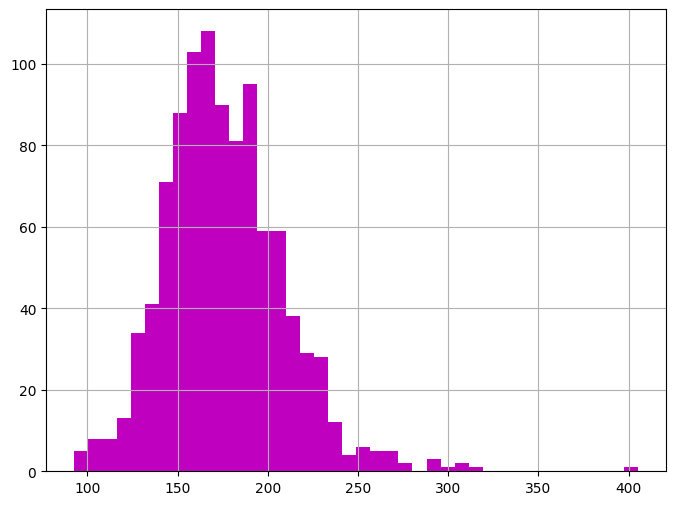

In [67]:
plt.hist(spotPrices, bins = 40, color = 'm')
plt.grid()
plt.show()

In [68]:
endPrice = prices[prices.index[-1]]
endPrice

175.56407165527344

And hence we can calculate statistics on it...
===

In [69]:
mean = spotPrices.mean()
std = spotPrices.std()
Quant95up = np.quantile(spotPrices,0.975)
Quant95down = np.quantile(spotPrices,0.0275)
print('Mean: ', mean)
print('Std: ', std)
print('95% Q: ', Quant95up)
print('5% Q: ', Quant95down)

Mean:  176.02709885829864
Std:  33.366429197873074
95% Q:  249.5254724172913
5% Q:  119.82319208886815


How do we set the intervals?
===

- This is more tricky as we need to get the percentiles at every forecasting step h, to obtain the "path for 95%" forecast e.g.

In [70]:
def getPathsExp(forecastSims, lastPrice):
    numSim = forecastSims.shape[0]
    numH = forecastSims.shape[1]
    print(numSim)
    print(numH)
    totValueAcrossPath = np.zeros(numSim)
    spotData = np.zeros((numSim,numH+1))
    for j in range(numSim): #for each path
        spotData[j,0]=lastPrice

    for j in range(numSim): #for each path
        for i in range(numH):
            spotData[j][i+1] = np.exp(forecastSims[j][i]/100)*spotData[j][i]

    return spotData

In [71]:
print(lastPrice)
spotPaths = getPathsExp(sims.values[1,:,:],lastPrice)

143.7454071044922
1000
100


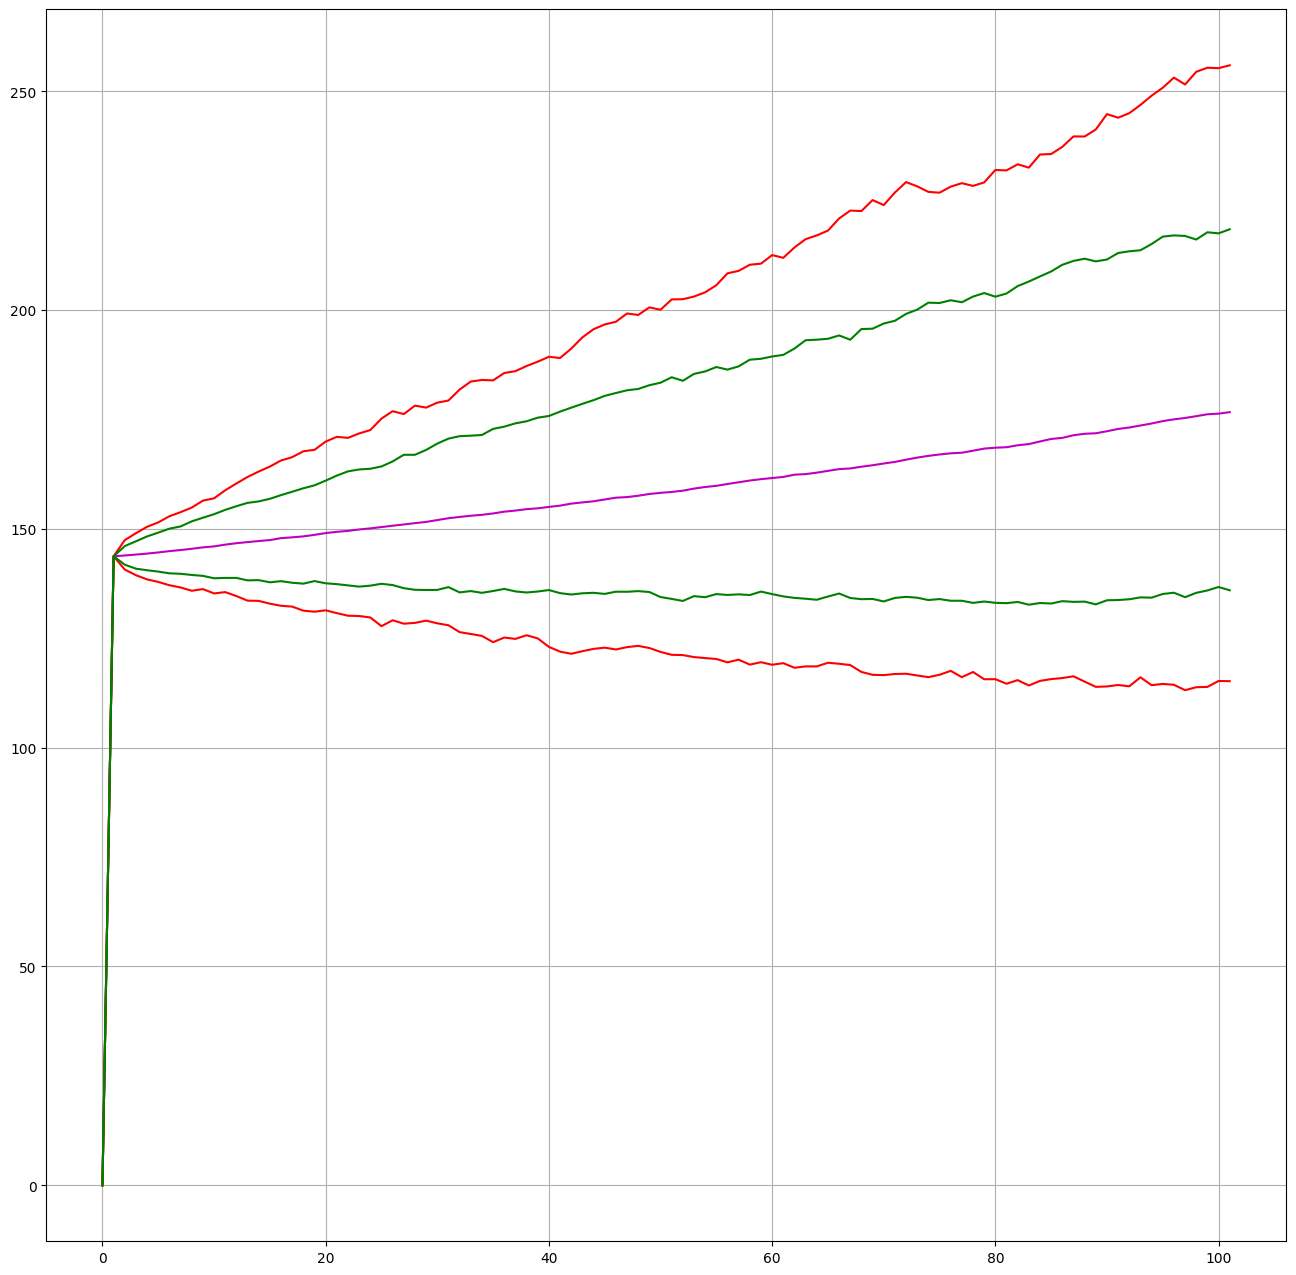

In [72]:
statsData = plotHorizonForecast(spotPaths[:,:],tsData=prices.loc[prices.index<split_date],getStats=True)
meanData = statsData['mean']

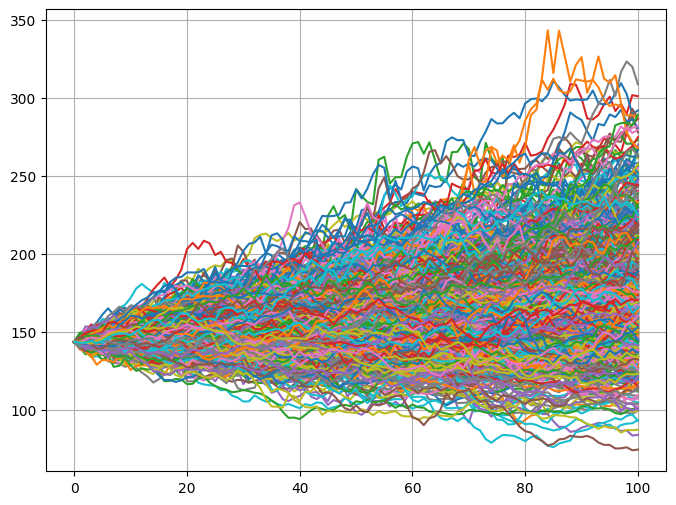

In [73]:
for k in range(1000):
    paths = spotPaths[k,:]
    plt.plot(paths);

plt.grid()
plt.show()

## if we want to specify residual distribution as student t distribution

In [74]:
from arch.univariate.distribution import StudentsT

newAAPLRet = AAPLRet*100
arx = ARX(newAAPLRet, lags= 4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
arx.distribution = StudentsT()
res_t = arx.fit(update_freq=0)
print(res_t.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7366.497676552143
            Iterations: 17
            Function evaluations: 199
            Gradient evaluations: 17
                              AR - GARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -7366.50
Distribution:      Standardized Student's t   AIC:                           14751.0
Method:                  Maximum Likelihood   BIC:                           14807.1
                                              No. Observations:                 3772
Date:                      Wed, Nov 22 2023   Df Residuals:                     3767
Time:                              03:08:55   Df Model:                            5
                         

In [75]:
std_resid = res_t.resid/res_t.conditional_volatility
std_resid = std_resid.dropna()

In [76]:
import scipy.stats as stats

def plot_diagnosticsTight3_t(data,df=0):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Data")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True,auto_ylims=True)
    ax3.grid()

    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,model_df=df)#package version

    ax4.plot(ljbox_test['lb_pvalue'])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()

    fig = sm.qqplot(data, stats.t,fit=True,line='q', ax = ax5)
    ax5.grid()

    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")

    plt.tight_layout()

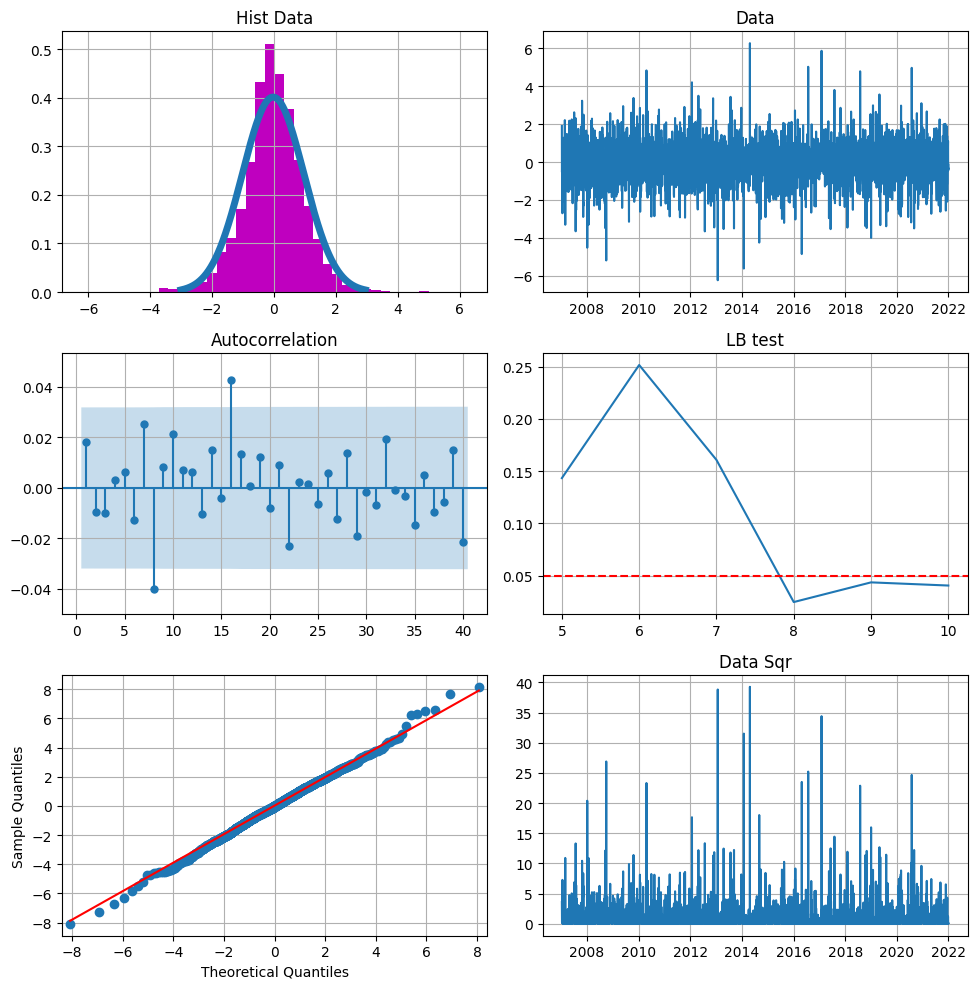

In [77]:
plot_diagnosticsTight3_t(std_resid,4)